In [ ]:
!pip install Sastrawi
!pip install sentence_transformers

     |████████████████████████████████| 215kB 4.3MB/s 
     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 2.3MB 19.1MB/s 
     |████████████████████████████████| 1.2MB 46.3MB/s 
     |████████████████████████████████| 3.3MB 37.0MB/s 
     |████████████████████████████████| 901kB 37.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=a3c4ca4df4c9c113180995f3d81a54552f7753ecc7f1561d90c7de906d22fe36
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


In [ ]:
from google.colab import drive
drive.mount("content/", force_remount=True)

Mounted at content/


Product Matching biasa digunakan untuk optimalisasi search produk berdasarkan teks maupun gambar atau keduanya (Multi modal search). Rencana pipeline Product Matching pada data Shopee ini adalah:


1.   Gambar: MobileNet CNN --> Image Embedding
2.   Text: BERT --> Text Embedding
3.   Gabung Image Embedding + Text Embedding
4.   Similarity Detection
5.   Supervised learning
6.   Top N similar text & image



In [ ]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### PREPROCESSING TEXT LIBRARY ###
import cv2
import nltk
from nltk import FreqDist
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


### SIMILARITY ALGO LIB ###
from scipy.stats import entropy
from gensim import corpora
import gensim.downloader as api
from gensim.models import LdaModel
from gensim.matutils import softcossim

from sklearn.metrics.pairwise import cosine_similarity, paired_cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

### EMBEDDINGS APPROACH ###
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import preprocessing
from sentence_transformers import SentenceTransformer, util



In [ ]:
### DOWNLOAD ###
model = SentenceTransformer('stsb-distilbert-base') # BERT = return sentence level embedding <== Pre-Trained Model
model.max_seq_len = 128
glove_api = api.load('glove-wiki-gigaword-50')
nltk.download('punkt')
nltk.download('stopwords')


[==================================================] 100.0% 66.0/66.0MB downloaded
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
training_dataframe = '/content/content/MyDrive/Bangkit/new_training_set (1) (1).csv'
images_dir = '/content/content/MyDrive/Bangkit/Images/training_img'

In [ ]:
df = pd.read_csv(training_dataframe)

## Product Matching

### First EDA

In [ ]:
label_dist = df['Label'].value_counts()

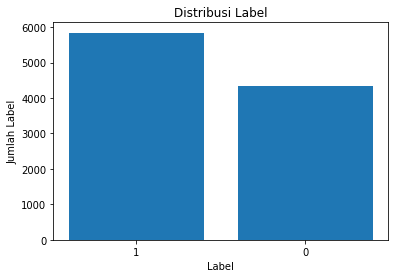


Total distribusi 1: 5844
Total distribusi 0: 4337


In [ ]:
plt.bar(label_dist.keys().astype('str'), label_dist)
plt.ylabel('Jumlah Label')
plt.xlabel('Label')
plt.title('Distribusi Label')
plt.show()
print(f'\nTotal distribusi 1: {label_dist[1]}')
print(f'Total distribusi 0: {label_dist[0]}')

Distribusi class balance (Tidak perlu resampling)

In [ ]:
start = 5
end = 10
for i in range(start, end):
  print('-'*5, df['Label'][i], '-'*5, f'idx({i})')
  print(df['title_1'][i])
  print(df['title_2'][i])
  print()

----- 1 ----- idx(5)
rokok elektrik evod 1100mAh
rokok elektric evod 1100mah

----- 1 ----- idx(6)
HIJAB INSTAN / JILBAB SERUT JOKOWI ADIBA
JILBAB SERUT ADIBA JOKOWI POLOS (1KG=10PCS) / JILBAB INSTAN

----- 0 ----- idx(7)
Hijab bergo 1 layer tali nonpet hijab instant diamond strecht
Khimar tali belakang

----- 0 ----- idx(8)
Korea 2019 Versi Korea Dari Musim Gugur Baru Sastra Retro Peas Sepatu Wanita Fila Perempuan New Year
Korea 2019 Versi Korea Dari Musim Gugur Baru Sastra Retro Peas Sepatu Wanita Fila Perempuan New Year

----- 1 ----- idx(9)
Juice Cup Blender Mini Portable/USB Blender Juicer/Alat Pembuat Jus
Blender Juice CUP Mini Portable



### All Fuctions

In [ ]:
def text_cleaning(teks, stem=False, remove_url=False):
    teks = str(teks)
    # Menghapus "New tab", "Tab"
    pattern_0 = r'[\n\t\r]'
    teks = re.sub(pattern_0, '', teks)
    
    # Remove non ASCII (emoticon, chinese word (if exists))
    teks = teks.encode('ascii', 'replace').decode('ascii')
    
    # Menghapus digit
    pattern_d = r'([0-9]*)'
    teks = re.sub(pattern_d, '', teks)
    
    # Case folding
    teks = teks.lower()
    
    if remove_url:
        # Remove url
        pattern_1 = r'((www\.[^\s]+)|(https?://[^\s]+))'
        teks = re.sub(pattern_1, '', teks)
        
    # Remove punctuation
    teks = teks.translate(str.maketrans("", "", punctuation))
    
    # Tokenize
    teks = word_tokenize(teks)
    
    # Remove stopwords
    stopword = set(stopwords.words('indonesian'))
    teks = [word for word in teks if not word in stopword]

    if stem:
      factory = StemmerFactory()
      stemmer = factory.create_stemmer()
      teks = stemmer.stem(teks)
    return teks

def replace_slang(teks, tokenize=False):
    if tokenize:
        teks = word_tokenize(teks)
    
    new_teks = []
    for word in teks:
        try:
            new_teks.append(slang_words[word])
            
        except KeyError:
            new_teks.append(word)
            
    return new_teks

def FrequencyDistribution(pandas_series, visualize=False, top=30):
    words_list = list(chain.from_iterable(pandas_series.tolist()))
    freq = FreqDist(words_list)
    
    if visualize:
        plt.figure(figsize=(12, 6))
        freq.plot(top)
        
    return freq

def normalize_dtype(doc, return_string=True):  
    if return_string:
        return ' '.join(ast.literal_eval(doc))
    
    return ast.literal_eval(doc)

def save_file(filename, data):
  import pickle
  with open(filename, 'wb') as f:
    pickle.dump(data, f)


### Start Analyze

In [ ]:
no = 13
text1 = df['title_1'][no]
text2 = df['title_2'][no]
LABEL = df['Label'][no]
text1_list = text_cleaning(text1)
text2_list = text_cleaning(text2)

In [ ]:
print(text1)
print(text2)
print(f'\n--- AFTER CLEANING --- LABEL: {LABEL}\n')
print(text1_list)
print(text2_list)

CHANEL BESI / SELEMPANG / BISA COD MIN ORDER 2 / REAL PICTURE
DOMPET CHANEL 2 RUANG / BISA COD / REAL PICTURE / SELEMPANG / WANITA / KERANG / TERMUrah / BATAm

--- AFTER CLEANING --- LABEL: 0

['chanel', 'besi', 'selempang', 'cod', 'min', 'order', 'real', 'picture']
['dompet', 'chanel', 'ruang', 'cod', 'real', 'picture', 'selempang', 'wanita', 'kerang', 'termurah', 'batam']


In [ ]:
### ALL SIMILARITY ALGO FUNCTIONS ###

def vectorizer(teks):
  tfidf = TfidfVectorizer()
  X = tfidf.fit_transform(teks)

  return X.toarray() # Return array

def jaccard_similarity(doc1, doc2):
  intersection = set(doc1).intersection(set(doc2)) # Memasukkan kata yang sama dari kedua dokumen
  union = set(doc1).union(set(doc2)) # Memasukkan semua kata unik dalam satu list
  return len(intersection)/len(union)

def cosineSimilarity(doc1, doc2, vectorize=True, soft=False):
  corpus = [doc1, doc2]
  
  if not soft:
    if vectorize:
      for idx, doc in enumerate(corpus):
        corpus[idx] = vectorizer(doc)
    
    return cosine_similarity(corpus[0].reshape(-1, 1), corpus[1].reshape(-1,1))

  else:
    dictionary = corpora.Dictionary(corpus)
    glove = glove_api # API glove untuk menambahkan konteks kalimat (Biasa digunakan pada kalimat pendek)
    sim_matrix = glove.similarity_matrix(dictionary=dictionary) # transform kata ke matrix berdasarkan BOW dari glove

    # Ubah menjadi Bag of Words (BOW)
    # Menghitung kemunculan kata masing-masing corpus berdasarkan dictionary (output: list of tuples)
    # Tuple masing-masing berisikan key dictionary dan jumlah kata masing-masing corpus
    # Ex: (0, 2) --> Kata key dict 0 muncul 2x pada corpus X
    corpus_0 = dictionary.doc2bow(corpus[0])
    corpus_1 = dictionary.doc2bow(corpus[1])

    return softcossim(corpus_0, corpus_1, sim_matrix)

def lstm_similarity(doc1, doc2):
  pass

def jsd_similarity(query, matrix, k=10):
  '''
  JSD (Jensen Shannon Distance)
  Parameter&Values:
    M: Jumlah dokumen pada korpus
    array of length M: Array yang berisi jumlah dokumen seluruh korpus
    query: distribusi topik LDA
    matrix: dense matrix dari distribusi LDA

  Returns:
    top K indices: nilai yang direturn adalah JSD dengan nilai terkecil. (Berdekatan)
  '''
  p = query[None,:].T
  q = matrix.T
  m = 0.5*(p + q)
  similarity = np.sqrt(0.5*(entropy(p, m) + entropy(q, m)))
  return similarity.argsort()[:k]
  
def lda_jsd(train, test, num_topics=10):
  '''
  Latent Dirichlet Allocation.
    LDA termasuk bagian dari unsupervised learning (generative model) untuk menentukan sebuah topik dari masing-masing kalimat.
  Pada situasi tertentu, kita dapat mengasumsikan bahwa pada 1 document (kalimat) biasanya terdiri dari beberapa topik, sehingga bisa 
  terjadi overlapping topik pada 1 dokumen.

    Hal yang penting pada algoritma LDA adalah: perlunya menentukan jumlah topik di awal analisis (Priori), karena memungkinkan terdapat
  kata-kata yang overlap diantara topik-topik yang ada. dengan kata lain beberapa topik memungkinkan terdiri dari kata-kata yang sama.
  Latent (Hidden variables): 1) distribusi beberapa topik pada setiap dokumen, 2) distribusi kata pada setiap topik.
  Contoh: "Pemilihan wali kota Surabaya Cak Eri". Kata-kata pada corpus tersebut hanya sedikit muncul pada corpus "Dzawin suka naik gunung"
  Sehingga kata-kata seperti "Pemilihan" "Wali Kota" "Surabaya" berkontribusi besar pada pengelompokan topik tersendiri, begitupun juga
  corpus satunya.

  Catatan: LDA tidak bekerja maksimal pada kalimat-kalimat yang pendek. ROT: <30 words maka DROP, LDA tidak memberi nama topik dan 
  hanya mengelompokkan saja. LDA adalah model yang menggunakan BOW, sehingga struktur kalimat tidak dipertimbangkan.
  '''
  corpus_train = train
  corpus_test = test
  dictionary = corpora.Dictionary(corpus_train)
  corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_train]
  corpus_bow_test = [dictionary.doc2bow(doc) for doc in corpus_test]

  # Model
  # nilai alpha rendah merepresentasikan jumlah topik yang sedikit, begitupun sebaliknya
  # nilai eta rendah artinya bahwa topik direpresentasikan dengan sedikit jumlah kata, dan sebaliknya
  lda = LdaModel(corpus=corpus_bow, num_topics=num_topics, id2word=dictionary, 
                 alpha=1e-2, eta=0.5e-2, minimum_probability=0.0, passes=2)
  
  new_doc_dist = [np.array(lda.get_document_topics(bow)) for bow in corpus_bow_test]
  doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus_bow]])
  # JSD (Jensen Shannon Divergence (SQRT dari Jensen Shannon Distance))
  # LDA harus berbentuk dense matrix (efficient commputation)
  sims = jsd_similarity(new_doc_dist, doc_topic_dist)
  return sims



In [ ]:
print(f'Cosine Similarity probability: {cosineSimilarity(text1_list, text2_list, soft=True)}')
print(f'Jaccard Simmilarity probability: {jaccard_similarity(text1_list, text2_list)}')

Cosine Similarity probability: 0.6056525676855156
Jaccard Simmilarity probability: 0.35714285714285715


### Embeddings Approach

In [ ]:
# Fix images path
df['image_1'] = df['image_1'].apply(lambda x: os.path.join(images_dir, x))
df['image_2'] = df['image_2'].apply(lambda x: os.path.join(images_dir, x))

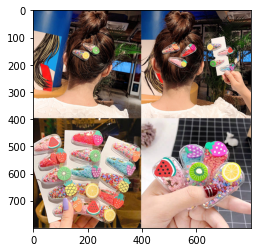

In [ ]:
index = np.random.choice(np.arange(df.shape[0]))
img = mpimg.imread(df['image_1'].iloc[index])
imgplot = plt.imshow(img)
plt.show()

In [ ]:
title_data = pd.concat([df['title_1'], df['title_2']], axis=0)
image_data = pd.concat([df['image_1'], df['image_2']], axis=0)
label_data = pd.concat([df['Label'].iloc[:df.shape[0]], df['Label'].iloc[:df.shape[0]]], axis=0)

In [ ]:
dataset = pd.DataFrame(zip(title_data, image_data), columns=['all_titles', 'all_images'])

In [ ]:
X = dataset
y = label_data

# SPLIT for TRAINING and TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [ ]:
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)

# include_top = False karena tujuan dari model bukan untuk klasifikasi namun untuk ekstra fitur dari gambar
img_model = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
def textEmbeddings(model, text):
  text_embeddings = model.encode(text, convert_to_tensor=True)
  return text_embeddings

def imageEmbeddings(model, image):
  image = preprocessing.image.load_img(image, target_size=size)
  input_array = np.array([preprocessing.image.img_to_array(image)])
  img_embeddings = model(input_array)

  # Mean Pooling
  AvgImgEmb1 = np.mean(img_embeddings, axis=0) # Reducing embeddings
  AvgImgEmb2 = np.mean(AvgImgEmb1, axis=0) # Reducing embeddings
  AvgImgEmb = np.mean(AvgImgEmb2, axis=0) # Final values
  return AvgImgEmb

In [ ]:
X_train['all_titles'] = X_train['all_titles'].astype('str')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Dont forget to turn colab config into GPU standard

text_embeddings = {}
image_embeddings = {}
for index, row in X_train.iterrows():
  # Convert all titles and images into embeddings
  txt_emb = textEmbeddings(model, row[0]) 
  img_emb = imageEmbeddings(img_model, row[1]) 

  # Assign embedded into dictionary (each of them)
  text_embeddings[index] = txt_emb
  image_embeddings[index] = img_emb

In [ ]:
import pickle
# Save trained model
with open('./textEmb_1', 'wb') as handle:
  pickle.dump(text_embeddings, handle)

with open('./imgEMb_1', 'wb') as handle:
  pickle.dump(image_embeddings, handle)

In [ ]:
def extract_emb_list(X, txt_emb, img_emb):
  keyList = [] # List to keep Post ID of paired title and image 
  combList = [] # List to keep combined embeddings (text & image)
  imageList = [] # List to keep image path
  titleList = [] # List to keep title text
  for index, row in X.iterrows():
    txt_emb = text_embeddings[index] # get text embeddings one by one via loop
    # print(len(image_embeddings[index]), end='\r')
    img_emb = image_embeddings[index] # get image embeddings one by one via loop
    img_emb = np.empty(1024)
    combined_emb = np.concatenate((txt_emb, img_emb), axis=0) # Combine text embeddings and image embeddings
    norm = np.linalg.norm(combined_emb) # Normalize values of combined embeddings
    combined_emb_normal = combined_emb/norm # Normalize combined embeddings
    
    # Appending
    keyList.append(index)
    combList.append(combined_emb_normal)
    imageList.append(row[1])
    titleList.append(row[0])

  return keyList, combList, imageList, titleList, txt_emb

In [ ]:
keyList, combList, imageList, titleList, txt_emb = extract_emb_list(X_train, text_embeddings, image_embeddings)

In [ ]:
(np.array(combList)).shape

(14253, 1792)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Model to get similarity distance
kn_model = NearestNeighbors(n_neighbors=5, leaf_size=5000, algorithm='kd_tree')
kn_model.fit(combList)

NearestNeighbors(algorithm='kd_tree', leaf_size=5000, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
txt_emb = textEmbeddings(model, "sandal jepit")

In [ ]:
def getNeighbors(query_emb):
  posting_id_list = []
  neigh_dist, neigh_idx = kn_model.kneighbors(X=query_emb.reshape(1, -1), n_neighbors=5, return_distance=True)
  for idx in neigh_idx:
    for idx_1 in idx:
      posting_id_list.append(str(idx_1))
  return posting_id_list

In [ ]:
postingIdList = []
matchesList = []
index = 0
for val in keyList:
  query_emb = combList[index]
  posting_id = getNeighbors(query_emb)
  postingIdList.append(val)
  matchesList.append(" ".join(posting_id))
  index += 1
  if index == 100:
    break

TypeError: ignored

Sky Goat Susu Kambing Etawa Bubuk Full Cream | SkyGoat Original
10999


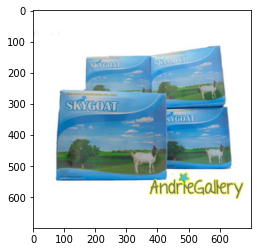

Sky Goat Susu Kambing Etawa Bubuk Full Cream | SkyGoat Original
10999


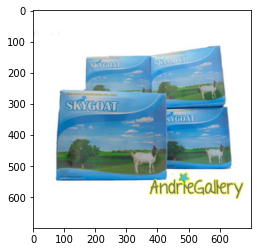

Skygoat Susu Kambing Etawa Bubuk Full Cream | Sky Goat Original Putih Vanila
2801


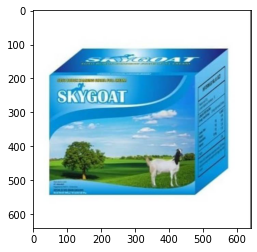

Terhitz kemeja panjang pria cowok gatlemen cowok biru navy dongker polos formal kantor murah
16878


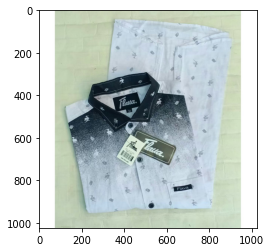

QnC Jelly Gamat Asli 100% Original - Fast Delivery (Garansi Uang Kembali Jika Palsu)
18351


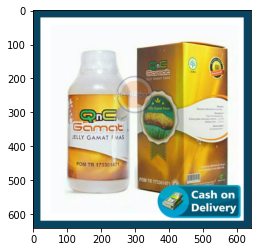

SPECIAL Lampu led natal | twinkle | string | tumblr | dekorasi - Warmwhite PALING MURAH
12047


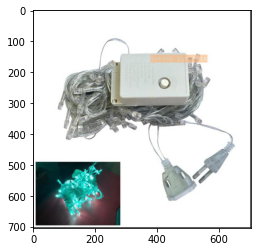

DAF01 FLATSHOES NEW ARRIVAL
18976


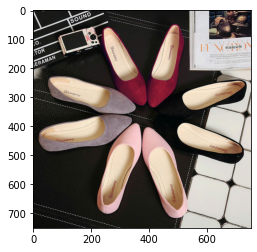

DAF01 FLATSHOES NEW ARRIVAL
18976


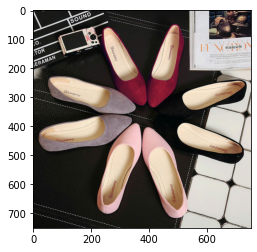

DAFF 01 FLATSHOES
64


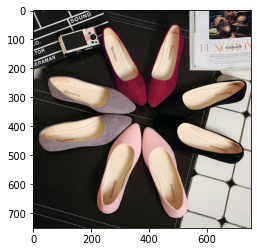

DAFF 01 FLATSHOES
8351


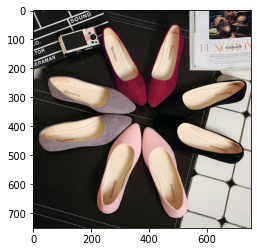

DAFF 01 FLATSHOES
8654


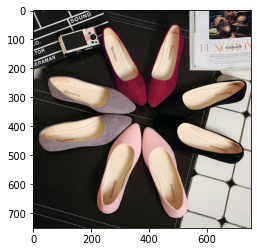

DAFF 01 FLATSHOES
6774


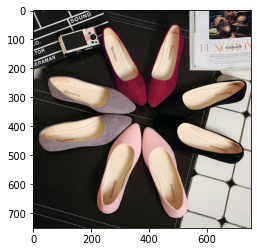

Kacamata Lensa Rangka Transparan Retro Vintage Metal Frame Eyeglasses
11159


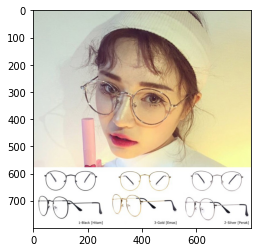

Kacamata Lensa Rangka Transparan Retro Vintage Metal Frame Eyeglasses
11159


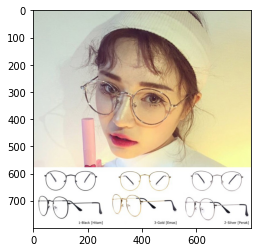

Kacamata Lensa Rangka Transparan Retro Vintage Metal Frame Eyeglasses
7614


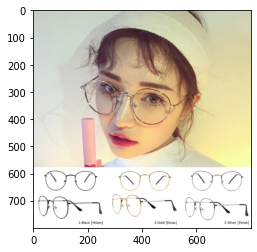

Kacamata Lensa Rangka Transparan Retro Vintage Metal Frame Eyeglasses
978


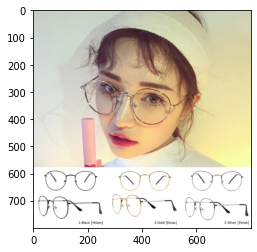

Kacamata Lensa Rangka Transparan Retro Vintage Metal Frame Eyeglasses
9251


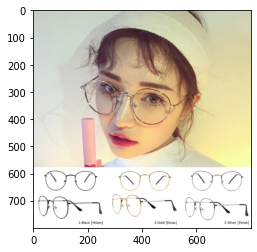

[Bayar Di Tempat]?Frame Kacamate?Korean Design Retro Bundar Besi Frame Eyeglasses Bening Lensa
11998


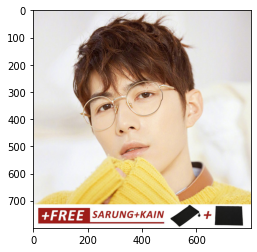

Mutiara Bros Korea bros Pin Brooch Berlian Wanita Aksesoris Fashion
4593


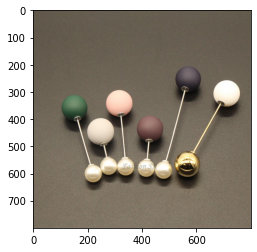

Mutiara Bros Korea bros Pin Brooch Berlian Wanita Aksesoris Fashion
4593


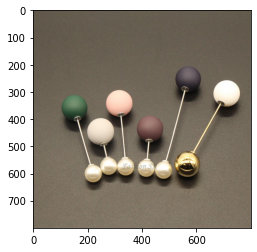

Mutiara Bros Korea bros Pin Brooch Berlian Wanita Aksesoris Fashion
7427


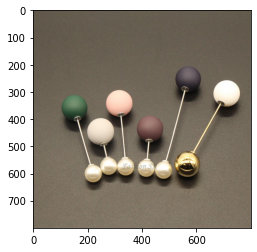

Mutiara Bros Korea bros Pin Brooch Berlian Wanita Aksesoris Fashion
4914


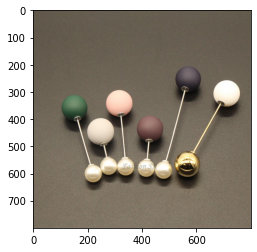

Mutiara Bros Korea bros Pin Brooch Berlian Wanita Aksesoris Fashion
6848


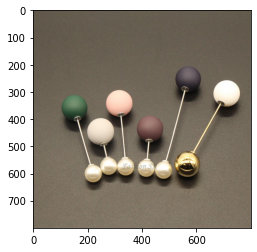

Mutiara Bros Korea bros Pin Brooch Berlian Wanita Aksesoris Fashion
5104


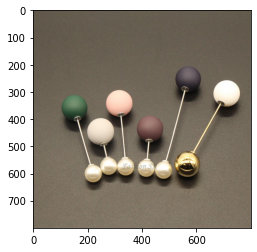

Koyok Kaki Kinoki White Foot Detox Isi 10 Lembar Kiyome White Cleansing Foot Pads | By Pratiwi Store
11307


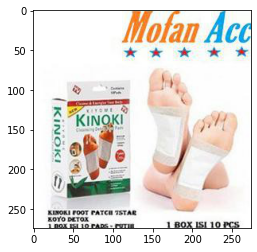

Koyok Kaki Kinoki White Foot Detox Isi 10 Lembar Kiyome White Cleansing Foot Pads | By Pratiwi Store
11307


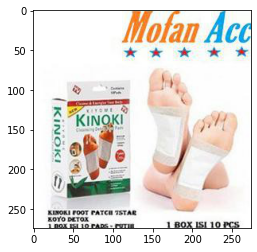

Koyo Kaki Kinoki White Foot Detox Isi 10 Lembar Kiyome White Cleansing Foot Pads
731


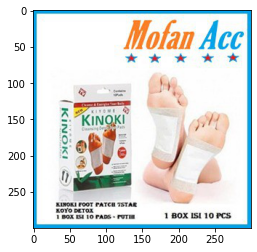

Koyo Kaki Kinoki White Foot Detox Isi 10 Lembar Kiyome White Cleansing Foot Pads
4223


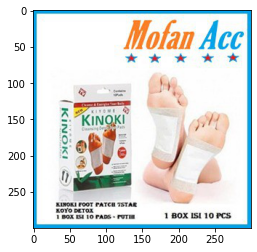

Koyo Kaki Kinoki White Foot Detox Isi 10 Lembar Kiyome White Cleansing Foot Pads
6281


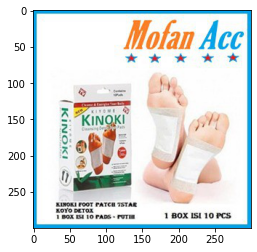

Koyo Kaki Kinoki White Foot Detox Isi 10 Lembar Kiyome White Cleansing Foot Pads
4622


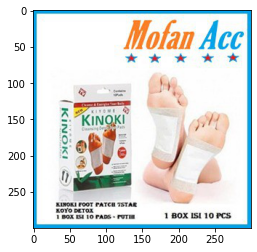

Bayar Di Tempat Kacamata Hitam Fashion Wanita Model Simple Transparan Tanpa Frame Untuk Pasangan
17710


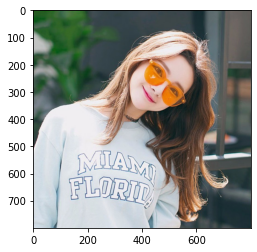

Bayar Di Tempat Kacamata Hitam Fashion Wanita Model Simple Transparan Tanpa Frame Untuk Pasangan
17710


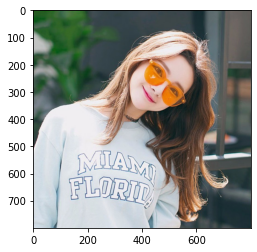

Bayar Di Tempat Kacamata Hitam Fashion Wanita Model Simple Transparan Tanpa Frame Untuk Pasangan
15765


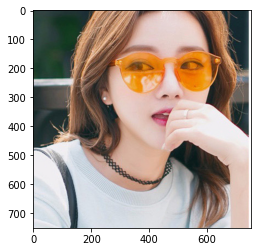

Bayar Di Tempat Kacamata Hitam Fashion Wanita Model Simple Transparan Tanpa Frame Untuk Pasangan
16737


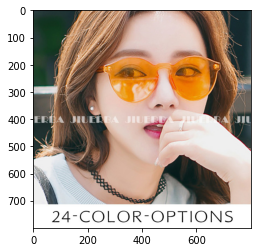

Bayar Di Tempat Kacamata Hitam Fashion Wanita Model Simple Transparan Tanpa Frame Untuk Pasangan
19725


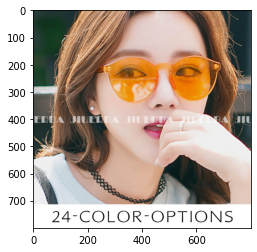

Kacamata Fashion Wanita Model Simple Transparan Tanpa Frame Untuk Pasangan
13342


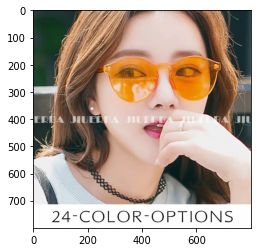

í(DISKON) TAS RANSEL SEQUIN LOL GLITTER LED RL008 DAN RL0017 TAS REMAJA WANITA TELINGA KELINCI //!!
19426


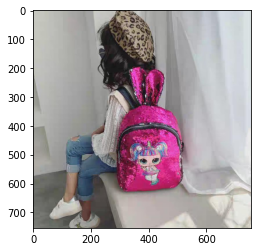

í(DISKON) TAS RANSEL SEQUIN LOL GLITTER LED RL008 DAN RL0017 TAS REMAJA WANITA TELINGA KELINCI //!!
19426


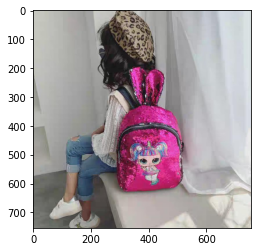

BIG SALE.!. TAS RANSEL SEQUIN LOL GLITTER LED RL008 DAN RL0017 TAS REMAJA WANITA TELINGA KELINCI
18996


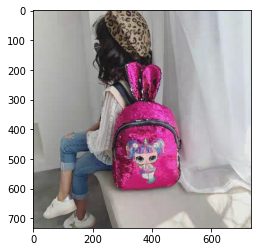

☛qw❁KT028 RANSEL SEQUIN TAS LOL USAP GLITTER TELINGA KELINCI LED NYALA SD SMP SMA WANITA RL008 & RL0
18010


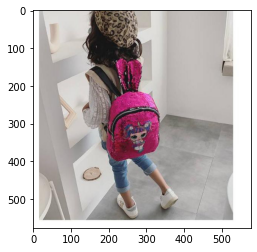

SALEE!!!! RANSEL SEQUIN TAS LOL USAP GLITTER TELINGA KELINCI LED NYALA SD SMP SMA WANITA RL008 & RL0
12053


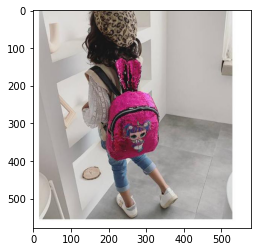

HON243 RANSEL SEQUIN TAS LOL USAP GLITTER TELINGA KELINCI LED NYALA SD SMP SMA WANITA RL008 & RL0017
10439


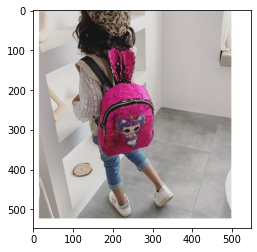

Promo Buy 1 Get 1 Samyang Green All Variant PerPack
19192


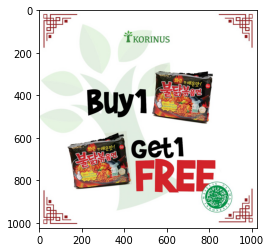

Promo Buy 1 Get 1 Samyang Green All Variant PerPack
19192


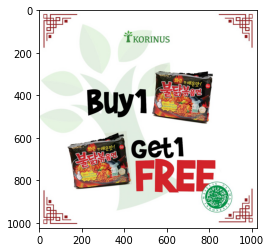

Promo Buy 1 Get 1 Samyang Green All Variant PerPcs
12052


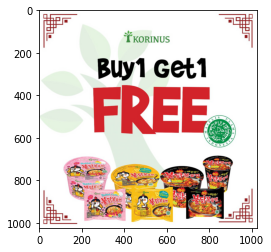

Promo Buy 1 Get 1 Samyang Green HCR Original 140gram (Kemasan Satuan 1 pc)
18627


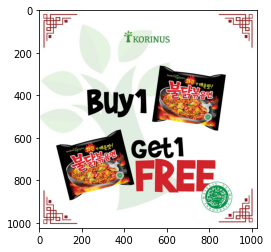

Promo Buy 1 Get 1 Samyang Green Original Small Cup
9011


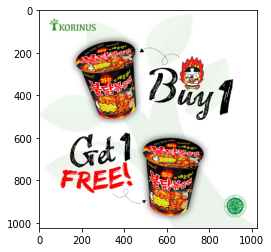

Promo Buy 1 Get 1 Samyang Green Original Small Cup
8446


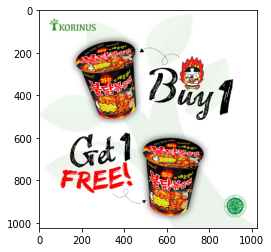

[ORIGINAL 🇰🇷] NATURE REPUBLIC REAL NATURE MASK SHEET/NATURE REPUBLIC SHEET MASK
16177


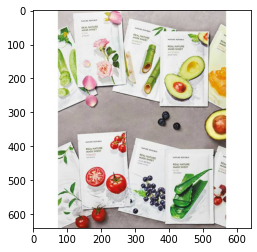

[ORIGINAL 🇰🇷] NATURE REPUBLIC REAL NATURE MASK SHEET/NATURE REPUBLIC SHEET MASK
16177


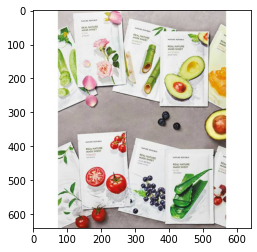

Nature Republic Real Nature Mask Sheet
388


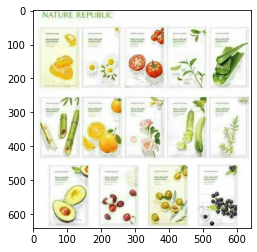

Nature Republic Real Nature Mask Sheet
652


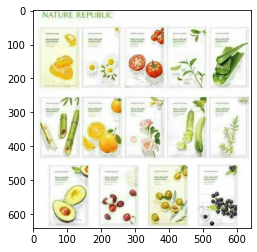

Nature Republic Real Nature Mask Sheet
3799


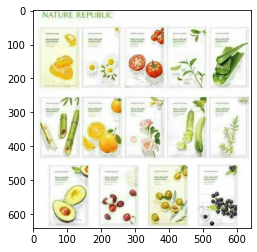

Nature Republic Real Nature Mask Sheet
8753


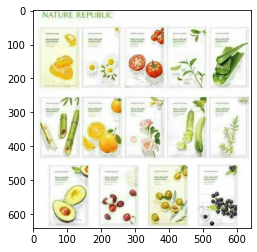

TOTE DINDA - Tas Tote Bag Wanita/ tas belanja /tas kuliah / tas sablon /totebag
15773


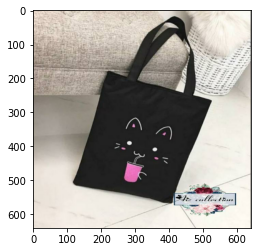

TOTE DINDA - Tas Tote Bag Wanita/ tas belanja /tas kuliah / tas sablon /totebag
15773


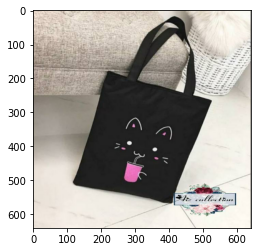

MORYMONY DINDA - Tote Bag
4711


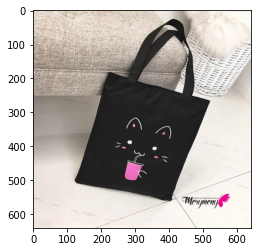

TOTE BAG DINDA / TOTEBAG DINDA
14892


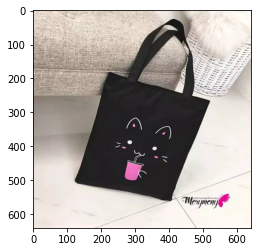

DOMMO - D1082 Tote Bag CHIO - Tote Bag (Bisa Ransel Bisa Selempang)
17206


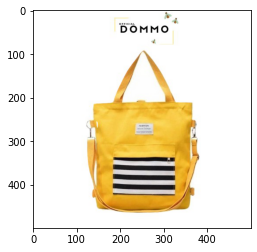

Terlaris DELI - E0010N / Refill Staples / Peralatan Sekolah Kantor Murah Awet - Setia Bisnis
12316


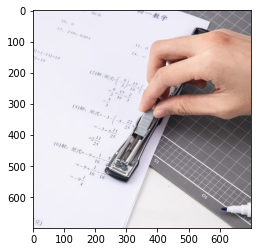

In [ ]:
from PIL import Image
index = 0
for item in postingIdList:
  print(titleList[index])
  print(keyList[index])
  pil_img = Image.open(imageList[index], 'r')
  plt.figure()
  plt.imshow(pil_img)
  plt.show()
  matching_idx = matchesList[index].split(' ')
  print('==================')
  for idx in matching_idx:
    print(titleList[int(idx)])
    print(keyList[int(idx)])
    pil_img = Image.open(imageList[int(idx)], 'r')
    plt.figure()
    plt.imshow(pil_img)
    plt.show()
  index += 1
  if index == 10:
    break

In [ ]:
i = 6
search_text = "ipone"
search = text_cleaning(search_text)
# print(df['title_1'].iloc[i])
print(search_text)
print('==========')
index = 0
for title in df['title_2']:
  cleaned_title = text_cleaning(title)
  if cosineSimilarity(search, cleaned_title, soft=True) > 0.6:
    print(title)
    index += 1
  
  if index == 10:
    break

ipone


## Deployment

In [ ]:
from flask import Flask, render_template, request

In [ ]:
app = Flask(__name__)

@app.route('/predict_title')
def predict_title(title_text, title_db, threshold=0.6, max_retrieve=10):
  search_id = data['search_id']
  search_text = data['title']
  title_list = []
  index = 0
  for title in title_db['title']:
    cleaned_title = text_cleaning(title)
    if cosineSimilarity(search_text, cleaned_title, soft=True) > 0.6:
      title_list.append(title)

    if index == max_retrieve:
      break

  return title_list

@app.route('/predict')
def predict(data):
  search_id = data['search_id']
  title_text = data['title']
  image = data['image']
  # Convert input data (JSON) into embeddings vector
  try:
    # Convert string to embeddings
    txt_emb = textEmbeddings(model, title_text)
  except:
    # If there is no string input then return NaN
    txt_emb = np.nan

  try:
    # Convert image (path) to embeddings
    img_emb = imageEmbeddings(img_model, image)
  except:
    # If there is no image input return NaN
    img_emb = np.nan

  # Combine text embeddings and image embeddings into one
  combined_emb = np.concatenate([txt_emb, img_emb], axis=0)

  # Normalize the distance between text embeddings and image embeddings
  norm = np.linalg.norm(combined_emb)
  norm_combined_emb = combined_emb/norm
  query_emb = norm_combined_emb

  posting_id_list = []
  neigh_dist, neigh_idx = kn_model.kneighbors(X=query_emb.reshape(1, -1), n_neighbors=5, return_distance=True)
  for idx in neigh_idx:
    for idx_1 in idx:
      posting_id_list.append(str(idx_1))
  return posting_id_list

In [ ]:
POST
{"title": "Pakan ayam"}


GET

[
{
    "Title": "Pakan ayam murah",
    "images": "google.app/bucket/asdadsfsdf.jpg"
},
{
    "Title": "Pakan ayam Surabaya murah",
    "images": "google.app/bucket/asdadadsfasdfaoswdfsfsdf.jpg"
},
{
    "Title": "Pakan ayam Surabaya murah",
    "images": "google.app/bucket/asdadadsfasdfaoswdfsfsdf.jpg"
}
]
